                            OLS Regression Results                            
Dep. Variable:             URR_winsor   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     14.91
Date:                Sun, 27 Jul 2025   Prob (F-statistic):           1.47e-09
Time:                        17:17:36   Log-Likelihood:                -180.86
No. Observations:                 272   AIC:                             381.7
Df Residuals:                     262   BIC:                             417.8
Df Model:                           9                                         
Covariance Type:              cluster                                         
                                                                  coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------

/Users/amirasrzad/anaconda3/envs/isr/lib/python3.11/site-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


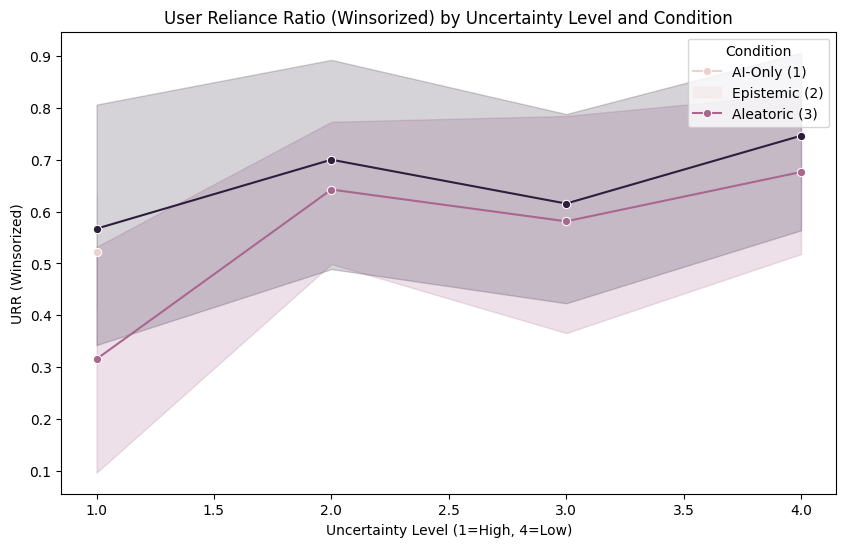

In [5]:
import pandas as pd
import numpy as np
from scipy.stats.mstats import winsorize
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
file_path = "/Users/amirasrzad/Library/CloudStorage/OneDrive-UMassLowell/1-Research/2-sambit/CIST-2025/experiment_insurance_cost/results/responses.24.july-pilot.csv"
df = pd.read_csv(file_path)

# Ensure relevant columns are numeric
cols_to_numeric = ['initial_guess', 'final_guess', 'predicted_charge', 'uncertainty_level', 'true_charge', 'age', 'bmi', 'task_number']
for col in cols_to_numeric:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df['condition'] = pd.to_numeric(df['condition'], errors='coerce').astype(int)
df['sex'] = df['sex'].astype('category')
df['smoker'] = df['smoker'].astype('category')

# Compute URR
df['URR'] = np.where(
    df['predicted_charge'] == df['initial_guess'],
    0,
    (df['final_guess'] - df['initial_guess']) / (df['predicted_charge'] - df['initial_guess'])
)

# Winsorize URR at 1% and 99%
df['URR_winsor'] = winsorize(df['URR'], limits=[0.01, 0.01])

# Fit OLS with clustered standard errors by prolific_id
formula = "URR_winsor ~ C(condition, Treatment(reference=1)) * uncertainty_level + task_number + age + C(sex) + bmi + C(smoker)"
model = smf.ols(formula, data=df)
res = model.fit(cov_type='cluster', cov_kwds={'groups': df['prolific_id']})

# Print model summary
print(res.summary())

# Hypothesis H1: Check interaction coefficients for condition 2 and 3 with uncertainty_level (should be positive and significant)
print("\nH1 Test: Interaction coefficients")
print("Epistemic (condition 2) interaction:", res.params['C(condition, Treatment(reference=1))[T.2]:uncertainty_level'])
print("p-value:", res.pvalues['C(condition, Treatment(reference=1))[T.2]:uncertainty_level'])
print("Aleatoric (condition 3) interaction:", res.params['C(condition, Treatment(reference=1))[T.3]:uncertainty_level'])
print("p-value:", res.pvalues['C(condition, Treatment(reference=1))[T.3]:uncertainty_level'])

# Hypothesis H2: Wald test to compare aleatoric vs epistemic interaction (aleatoric > epistemic)
wald_test_h2 = res.wald_test("C(condition, Treatment(reference=1))[T.3]:uncertainty_level - C(condition, Treatment(reference=1))[T.2]:uncertainty_level = 0")
print("\nH2 Test: Wald test for aleatoric interaction > epistemic interaction")
print(wald_test_h2)

# Exploratory: Compute MAE for final guesses
df['MAE'] = abs(df['final_guess'] - df['true_charge'])
mae_by_condition = df.groupby('condition')['MAE'].mean()
print("\nMean Absolute Error (MAE) by Condition:")
print(mae_by_condition)

# Plot URR by uncertainty_level and condition
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='uncertainty_level', y='URR_winsor', hue='condition', marker='o')
plt.title('User Reliance Ratio (Winsorized) by Uncertainty Level and Condition')
plt.xlabel('Uncertainty Level (1=High, 4=Low)')
plt.ylabel('URR (Winsorized)')
plt.legend(title='Condition', labels=['AI-Only (1)', 'Epistemic (2)', 'Aleatoric (3)'])
plt.show()

In [7]:
file_path = "/Users/amirasrzad/Library/CloudStorage/OneDrive-UMassLowell/1-Research/2-sambit/CIST-2025/experiment_insurance_cost/results/responses.24.july-pilot.csv"
df = pd.read_csv(file_path)

# Ensure relevant columns are numeric
cols_to_numeric = ['initial_guess', 'final_guess', 'predicted_charge', 'uncertainty_level', 'true_charge', 'age', 'bmi', 'task_number']
for col in cols_to_numeric:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df['condition'] = pd.to_numeric(df['condition'], errors='coerce').astype(int)
df['sex'] = df['sex'].astype('category')
df['smoker'] = df['smoker'].astype('category')

# Compute URR
df['URR'] = np.where(
    df['predicted_charge'] == df['initial_guess'],
    0,
    (df['final_guess'] - df['initial_guess']) / (df['predicted_charge'] - df['initial_guess'])
)
# Ensure task_duration_ms is numeric
df['task_duration_ms'] = pd.to_numeric(df['task_duration_ms'], errors='coerce')

# Calculate average URR per prolific_id
avg_urr = df.groupby('prolific_id')['URR'].mean().reset_index(name='avg_URR')

# Calculate average task_duration_ms per prolific_id
avg_duration = df.groupby('prolific_id')['task_duration_ms'].mean().reset_index(name='avg_duration')

# Merge the two DataFrames on prolific_id
merged = pd.merge(avg_urr, avg_duration, on='prolific_id')

# Calculate the correlation between avg_URR and avg_duration
correlation = merged['avg_URR'].corr(merged['avg_duration'])
print("Correlation between average URR and average task duration:", correlation)

Correlation between average URR and average task duration: 0.5493109904286642


In [8]:
# Determine the AI suggested direction
df['ai_direction_up'] = df['predicted_charge'] > df['initial_guess']
df['ai_direction_down'] = df['predicted_charge'] < df['initial_guess']

# Determine participant's movement direction
df['participant_moved_up'] = df['final_guess'] > df['initial_guess']
df['participant_moved_down'] = df['final_guess'] < df['initial_guess']

# Cases where AI suggests a direction (exclude equals)
valid_cases = df[(df['ai_direction_up'] | df['ai_direction_down'])]

# Check if participant moved in the AI's suggested direction
valid_cases['followed_direction'] = (
    (valid_cases['ai_direction_up'] & valid_cases['participant_moved_up']) |
    (valid_cases['ai_direction_down'] & valid_cases['participant_moved_down'])
)

# Calculate percentage
if len(valid_cases) > 0:
    percentage = (valid_cases['followed_direction'].sum() / len(valid_cases)) * 100
    print(f"Percentage of records where participants moved in the AI's suggested direction: {percentage:.2f}%")
else:
    print("No valid cases where AI suggested a direction.")

Percentage of records where participants moved in the AI's suggested direction: 75.78%


In [10]:
# Identify cases where participant moved opposite to AI's direction
df['opposite_movement'] = (
    (df['ai_direction_up'] & df['participant_moved_down']) |
    (df['ai_direction_down'] & df['participant_moved_up'])
)

# Filter the DataFrame for opposite movements
opposite_df = df[df['opposite_movement']]

# Display the DataFrame
opposite_df

,id,prolific_id,task_number,condition,initial_guess,final_guess,predicted_charge,uncertainty_level,true_charge,age,...,epistemic_uncertainty_std,aleatoric_uncertainty_std,task_duration_ms,created_at,URR,ai_direction_up,ai_direction_down,participant_moved_up,participant_moved_down,opposite_movement
76,776,5623f187ed6e5a0011c81083,5,2,8000,8100,7367,3,24060,19,...,552,11031,10833.948370,2025-07-24 21:28:15+00,-0.157978,False,True,True,False,True
96,796,664bf2201abae3378784ee1a,1,2,34159,22907,42710,1,58571,31,...,1211,3634,9530.291080,2025-07-24 21:29:06+00,-1.315869,True,False,False,True,True
97,797,664bf2201abae3378784ee1a,2,2,32314,26240,40164,1,52591,60,...,1065,5795,2792.649508,2025-07-24 21:29:14+00,-0.773758,True,False,False,True,True
100,800,664bf2201abae3378784ee1a,5,2,14835,33077,7367,3,24060,19,...,552,11031,2831.668615,2025-07-24 21:29:39+00,-2.442689,False,True,True,False,True
101,801,664bf2201abae3378784ee1a,6,2,43299,44530,33285,3,43579,57,...,611,5002,3267.469883,2025-07-24 21:29:49+00,-0.122928,False,True,True,False,True
102,802,664bf2201abae3378784ee1a,7,2,31352,33761,11930,4,11879,55,...,148,1383,5758.738995,2025-07-24 21:30:00+00,-0.124035,False,True,True,False,True
103,803,664bf2201abae3378784ee1a,8,2,42417,43505,10022,4,10065,53,...,158,958,3753.376961,2025-07-24 21:30:13+00,-0.033585,False,True,True,False,True
105,805,67dd5fadfc2865707aedb5b0,2,3,37106,50039,10037,1,6552,33,...,919,9649,16332.355500,2025-07-24 21:27:55+00,-0.477779,False,True,True,False,True
109,809,67dd5fadfc2865707aedb5b0,6,3,38711,44045,4404,3,2711,19,...,329,5775,25789.189820,2025-07-24 21:29:45+00,-0.155478,False,True,True,False,True
122,822,66324535fc1d7a68f0e2bdbb,3,1,9428,9259,9651,1,6113,31,...,523,10505,15900.716780,2025-07-24 21:29:46+00,-0.757848,True,False,False,True,True


                            OLS Regression Results                            
Dep. Variable:             URR_winsor   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     26.67
Date:                Sun, 27 Jul 2025   Prob (F-statistic):           1.71e-12
Time:                        23:47:54   Log-Likelihood:                -140.03
No. Observations:                 243   AIC:                             300.1
Df Residuals:                     233   BIC:                             335.0
Df Model:                           9                                         
Covariance Type:              cluster                                         
                                                                  coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------

/Users/amirasrzad/anaconda3/envs/isr/lib/python3.11/site-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
/var/folders/cw/9zk590x916n51dgf9c5y4m7r0000gn/T/ipykernel_27802/449510973.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['MAE'] = abs(filtered_df['final_guess'] - filtered_df['true_charge'])


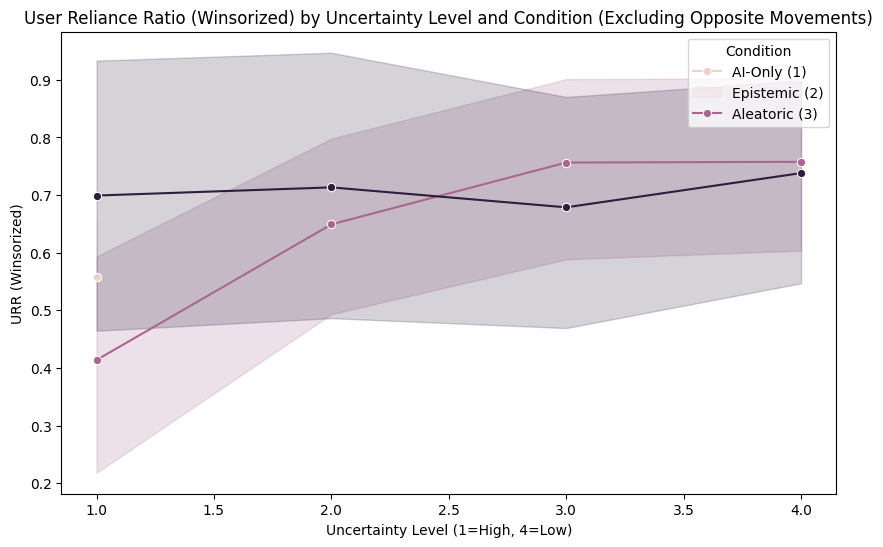

In [11]:
import pandas as pd
import numpy as np
from scipy.stats.mstats import winsorize
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
file_path = "/Users/amirasrzad/Library/CloudStorage/OneDrive-UMassLowell/1-Research/2-sambit/CIST-2025/experiment_insurance_cost/results/responses.24.july-pilot.csv"
df = pd.read_csv(file_path)

# Ensure relevant columns are numeric
cols_to_numeric = ['initial_guess', 'final_guess', 'predicted_charge', 'uncertainty_level', 'true_charge', 'age', 'bmi', 'task_number']
for col in cols_to_numeric:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df['condition'] = pd.to_numeric(df['condition'], errors='coerce').astype(int)
df['sex'] = df['sex'].astype('category')
df['smoker'] = df['smoker'].astype('category')

# Compute URR
df['URR'] = np.where(
    df['predicted_charge'] == df['initial_guess'],
    0,
    (df['final_guess'] - df['initial_guess']) / (df['predicted_charge'] - df['initial_guess'])
)

# Winsorize URR at 1% and 99%
df['URR_winsor'] = winsorize(df['URR'], limits=[0.01, 0.01])

# Determine the AI suggested direction
df['ai_direction_up'] = df['predicted_charge'] > df['initial_guess']
df['ai_direction_down'] = df['predicted_charge'] < df['initial_guess']

# Determine participant's movement direction
df['participant_moved_up'] = df['final_guess'] > df['initial_guess']
df['participant_moved_down'] = df['final_guess'] < df['initial_guess']

# Identify opposite movements
df['opposite_movement'] = (
    (df['ai_direction_up'] & df['participant_moved_down']) |
    (df['ai_direction_down'] & df['participant_moved_up'])
)

# Exclude opposite movements from analysis
filtered_df = df[~df['opposite_movement']]

# Fit OLS with clustered standard errors by prolific_id on filtered data
formula = "URR_winsor ~ C(condition, Treatment(reference=1)) * uncertainty_level + task_number + age + C(sex) + bmi + C(smoker)"
model = smf.ols(formula, data=filtered_df)
res = model.fit(cov_type='cluster', cov_kwds={'groups': filtered_df['prolific_id']})

# Print model summary
print(res.summary())

# Hypothesis H1: Check interaction coefficients for condition 2 and 3 with uncertainty_level (should be positive and significant)
print("\nH1 Test: Interaction coefficients")
print("Epistemic (condition 2) interaction:", res.params['C(condition, Treatment(reference=1))[T.2]:uncertainty_level'])
print("p-value:", res.pvalues['C(condition, Treatment(reference=1))[T.2]:uncertainty_level'])
print("Aleatoric (condition 3) interaction:", res.params['C(condition, Treatment(reference=1))[T.3]:uncertainty_level'])
print("p-value:", res.pvalues['C(condition, Treatment(reference=1))[T.3]:uncertainty_level'])

# Hypothesis H2: Wald test to compare aleatoric vs epistemic interaction (aleatoric > epistemic)
wald_test_h2 = res.wald_test("C(condition, Treatment(reference=1))[T.3]:uncertainty_level - C(condition, Treatment(reference=1))[T.2]:uncertainty_level = 0")
print("\nH2 Test: Wald test for aleatoric interaction > epistemic interaction")
print(wald_test_h2)

# Exploratory: Compute MAE for final guesses on filtered data
filtered_df['MAE'] = abs(filtered_df['final_guess'] - filtered_df['true_charge'])
mae_by_condition = filtered_df.groupby('condition')['MAE'].mean()
print("\nMean Absolute Error (MAE) by Condition:")
print(mae_by_condition)

# Plot URR by uncertainty_level and condition on filtered data
plt.figure(figsize=(10, 6))
sns.lineplot(data=filtered_df, x='uncertainty_level', y='URR_winsor', hue='condition', marker='o')
plt.title('User Reliance Ratio (Winsorized) by Uncertainty Level and Condition (Excluding Opposite Movements)')
plt.xlabel('Uncertainty Level (1=High, 4=Low)')
plt.ylabel('URR (Winsorized)')
plt.legend(title='Condition', labels=['AI-Only (1)', 'Epistemic (2)', 'Aleatoric (3)'])
plt.show()

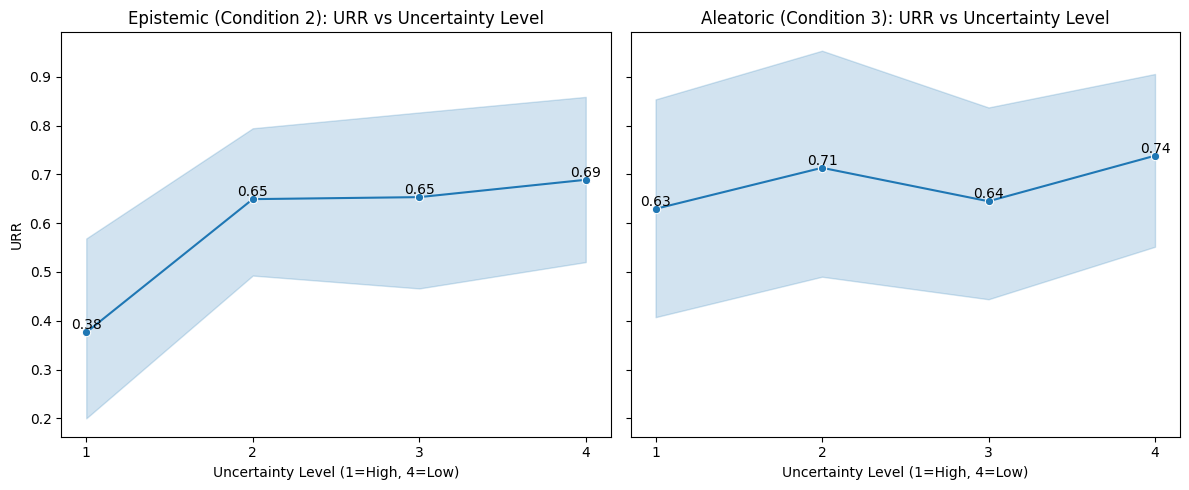

In [16]:

import pandas as pd
import numpy as np
from scipy.stats.mstats import winsorize
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
file_path = "/Users/amirasrzad/Library/CloudStorage/OneDrive-UMassLowell/1-Research/2-sambit/CIST-2025/experiment_insurance_cost/results/responses.24.july-pilot.csv"
df = pd.read_csv(file_path)

# Ensure relevant columns are numeric
cols_to_numeric = ['initial_guess', 'final_guess', 'predicted_charge', 'uncertainty_level', 'true_charge', 'age', 'bmi', 'task_number']
for col in cols_to_numeric:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df['condition'] = pd.to_numeric(df['condition'], errors='coerce').astype(int)
df['sex'] = df['sex'].astype('category')
df['smoker'] = df['smoker'].astype('category')

# Compute URR
df['URR'] = np.where(
    df['predicted_charge'] == df['initial_guess'],
    0,
    (df['final_guess'] - df['initial_guess']) / (df['predicted_charge'] - df['initial_guess'])
)

# Determine the AI suggested direction
df['ai_direction_up'] = df['predicted_charge'] > df['initial_guess']
df['ai_direction_down'] = df['predicted_charge'] < df['initial_guess']

# Determine participant's movement direction
df['participant_moved_up'] = df['final_guess'] > df['initial_guess']
df['participant_moved_down'] = df['final_guess'] < df['initial_guess']

# Identify opposite movements and set URR to 0 for those cases
df['opposite_movement'] = (
    (df['ai_direction_up'] & df['participant_moved_down']) |
    (df['ai_direction_down'] & df['participant_moved_up'])
)
df['URR_adjusted'] = np.where(df['opposite_movement'], 0, df['URR'])

# Winsorize adjusted URR at 1% and 99%
df['URR_winsor'] = winsorize(df['URR_adjusted'], limits=[0.01, 0.01])

# Create a figure with two subplots for conditions 2 and 3
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Filter data for condition 2 (Epistemic) and plot
cond2_df = df[df['condition'] == 2]
sns.lineplot(data=cond2_df, x='uncertainty_level', y='URR_winsor', marker='o', ax=axes[0])
axes[0].set_title('Epistemic (Condition 2): URR vs Uncertainty Level')
axes[0].set_xlabel('Uncertainty Level (1=High, 4=Low)')
axes[0].set_ylabel('URR')
axes[0].set_xticks([1, 2, 3, 4])

# Add text annotations for condition 2
for level in [1, 2, 3, 4]:
    mean_urr = cond2_df[cond2_df['uncertainty_level'] == level]['URR_winsor'].mean()
    if not np.isnan(mean_urr):
        axes[0].text(level, mean_urr, f'{mean_urr:.2f}', ha='center', va='bottom')

# Filter data for condition 3 (Aleatoric) and plot
cond3_df = df[df['condition'] == 3]
sns.lineplot(data=cond3_df, x='uncertainty_level', y='URR_winsor', marker='o', ax=axes[1])
axes[1].set_title('Aleatoric (Condition 3): URR vs Uncertainty Level')
axes[1].set_xlabel('Uncertainty Level (1=High, 4=Low)')
axes[1].set_xticks([1, 2, 3, 4])

# Add text annotations for condition 3
for level in [1, 2, 3, 4]:
    mean_urr = cond3_df[cond3_df['uncertainty_level'] == level]['URR_winsor'].mean()
    if not np.isnan(mean_urr):
        axes[1].text(level, mean_urr, f'{mean_urr:.2f}', ha='center', va='bottom')

# Adjust layout and show plot
plt.tight_layout()
plt.show()

Number of observations for Condition 1 (AI-Only): 88
Number of observations for Condition 2 (Epistemic): 88
Number of observations for Condition 3 (Aleatoric): 80

Data distribution by condition and uncertainty level:
condition  uncertainty_level
1          0                    88
2          1                    22
           2                    22
           3                    22
           4                    22
3          1                    20
           2                    20
           3                    20
           4                    20
dtype: int64
                            OLS Regression Results                            
Dep. Variable:             URR_winsor   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     1.686
Date:                Wed, 30 Jul 2025   Prob (F-statistic):              0.178
Time:                        0

/Users/amirasrzad/anaconda3/envs/isr/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 4
  warnings.warn('covariance of constraints does not have full '
/Users/amirasrzad/anaconda3/envs/isr/lib/python3.11/site-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


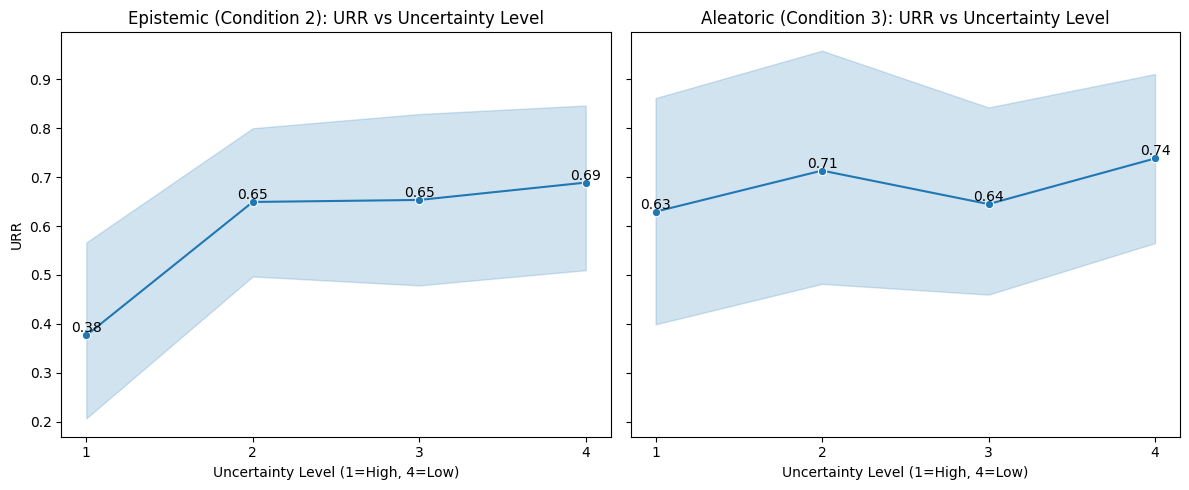

In [36]:
import pandas as pd
import numpy as np
from scipy.stats.mstats import winsorize
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
file_path = "/Users/amirasrzad/Library/CloudStorage/OneDrive-UMassLowell/1-Research/2-sambit/CIST-2025/experiment_insurance_cost/results/responses.24.july-pilot.csv"
df = pd.read_csv(file_path)

# Ensure relevant columns are numeric
cols_to_numeric = ['initial_guess', 'final_guess', 'predicted_charge', 'uncertainty_level', 'true_charge']
for col in cols_to_numeric:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df['condition'] = pd.to_numeric(df['condition'], errors='coerce').astype(int)

# Compute URR
df['URR'] = np.where(
    df['predicted_charge'] == df['initial_guess'],
    0,
    (df['final_guess'] - df['initial_guess']) / (df['predicted_charge'] - df['initial_guess'])
)

# Determine the AI suggested direction
df['ai_direction_up'] = df['predicted_charge'] > df['initial_guess']
df['ai_direction_down'] = df['predicted_charge'] < df['initial_guess']

# Determine participant's movement direction
df['participant_moved_up'] = df['final_guess'] > df['initial_guess']
df['participant_moved_down'] = df['final_guess'] < df['initial_guess']

# Identify opposite movements and set URR to 0 for those cases
df['opposite_movement'] = (
    (df['ai_direction_up'] & df['participant_moved_down']) |
    (df['ai_direction_down'] & df['participant_moved_up'])
)
df['URR_adjusted'] = np.where(df['opposite_movement'], 0, df['URR'])

# Winsorize adjusted URR at 1% and 99%
df['URR_winsor'] = winsorize(df['URR_adjusted'], limits=[0.01, 0.01])

# Check data availability for conditions 1, 2, and 3
cond1_data = df[df['condition'] == 1]
cond2_data = df[df['condition'] == 2]
cond3_data = df[df['condition'] == 3]
print(f"Number of observations for Condition 1 (AI-Only): {len(cond1_data)}")
print(f"Number of observations for Condition 2 (Epistemic): {len(cond2_data)}")
print(f"Number of observations for Condition 3 (Aleatoric): {len(cond3_data)}")
print("\nData distribution by condition and uncertainty level:")
print(df.groupby(['condition', 'uncertainty_level']).size())

# Fit OLS with clustered standard errors by prolific_id if data exists
if len(cond1_data) >= 2 and len(cond2_data) >= 2 and len(cond3_data) >= 2:
    formula = "URR_winsor ~ C(condition, Treatment(reference=1)) * uncertainty_level"
    model = smf.ols(formula, data=df)
    res = model.fit(cov_type='cluster', cov_kwds={'groups': df['prolific_id']})

    # Print model summary
    print(res.summary())

    # Hypothesis H1: Check interaction coefficients for condition 2 and 3 with uncertainty_level
    print("\nH1 Test: Interaction coefficients")
    print("Epistemic (condition 2) interaction:", res.params.get('C(condition, Treatment(reference=1))[T.2]:uncertainty_level', 'Not estimated (insufficient data)'))
    print("p-value:", res.pvalues.get('C(condition, Treatment(reference=1))[T.2]:uncertainty_level', 'Not estimated (insufficient data)'))
    print("Aleatoric (condition 3) interaction:", res.params.get('C(condition, Treatment(reference=1))[T.3]:uncertainty_level', 'Not estimated (insufficient data)'))
    print("p-value:", res.pvalues.get('C(condition, Treatment(reference=1))[T.3]:uncertainty_level', 'Not estimated (insufficient data)'))

    # Hypothesis H2: Wald test to compare aleatoric vs epistemic interaction
    if 'C(condition, Treatment(reference=1))[T.2]:uncertainty_level' in res.params and 'C(condition, Treatment(reference=1))[T.3]:uncertainty_level' in res.params:
        wald_test_h2 = res.wald_test("C(condition, Treatment(reference=1))[T.3]:uncertainty_level - C(condition, Treatment(reference=1))[T.2]:uncertainty_level = 0")
        print("\nH2 Test: Wald test for aleatoric interaction vs. epistemic")
        print(wald_test_h2)
    else:
        print("\nH2 Test: Cannot perform Wald test (interaction terms not estimated)")
else:
    print("Insufficient data for OLS model: Need at least 2 observations per condition.")

# Exploratory: Compute MAE for final guesses
df['MAE'] = abs(df['final_guess'] - df['true_charge'])
mae_by_condition = df.groupby('condition')['MAE'].mean()
print("\nMean Absolute Error (MAE) by Condition:")
print(mae_by_condition)

# Create a figure with two subplots for conditions 2 and 3
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Filter data for condition 2 (Epistemic) and plot
cond2_df = df[df['condition'] == 2]
if len(cond2_df) > 0:
    sns.lineplot(data=cond2_df, x='uncertainty_level', y='URR_winsor', marker='o', ax=axes[0])
    axes[0].set_title('Epistemic (Condition 2): URR vs Uncertainty Level')
    axes[0].set_xlabel('Uncertainty Level (1=High, 4=Low)')
    axes[0].set_ylabel('URR')
    axes[0].set_xticks([1, 2, 3, 4])
    # Add text annotations for condition 2
    for level in [1, 2, 3, 4]:
        mean_urr = cond2_df[cond2_df['uncertainty_level'] == level]['URR_winsor'].mean()
        if not np.isnan(mean_urr):
            axes[0].text(level, mean_urr, f'{mean_urr:.2f}', ha='center', va='bottom')
else:
    axes[0].text(0.5, 0.5, 'No data for Condition 2', ha='center', va='center')
    axes[0].set_title('Epistemic (Condition 2): URR vs Uncertainty Level')
    axes[0].set_xlabel('Uncertainty Level (1=High, 4=Low)')
    axes[0].set_ylabel('URR')
    axes[0].set_xticks([1, 2, 3, 4])

# Filter data for condition 3 (Aleatoric) and plot
cond3_df = df[df['condition'] == 3]
if len(cond3_df) > 0:
    sns.lineplot(data=cond3_df, x='uncertainty_level', y='URR_winsor', marker='o', ax=axes[1])
    axes[1].set_title('Aleatoric (Condition 3): URR vs Uncertainty Level')
    axes[1].set_xlabel('Uncertainty Level (1=High, 4=Low)')
    axes[1].set_xticks([1, 2, 3, 4])
    # Add text annotations for condition 3
    for level in [1, 2, 3, 4]:
        mean_urr = cond3_df[cond3_df['uncertainty_level'] == level]['URR_winsor'].mean()
        if not np.isnan(mean_urr):
            axes[1].text(level, mean_urr, f'{mean_urr:.2f}', ha='center', va='bottom')
else:
    axes[1].text(0.5, 0.5, 'No data for Condition 3', ha='center', va='center')
    axes[1].set_title('Aleatoric (Condition 3): URR vs Uncertainty Level')
    axes[1].set_xlabel('Uncertainty Level (1=High, 4=Low)')
    axes[1].set_xticks([1, 2, 3, 4])

# Adjust layout and show plot
plt.tight_layout()
plt.show()

Number of observations for Condition 2 (Epistemic): 44
Number of observations for Condition 3 (Aleatoric): 40
                            OLS Regression Results                            
Dep. Variable:             URR_winsor   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     2.324
Date:                Wed, 30 Jul 2025   Prob (F-statistic):              0.106
Time:                        03:34:34   Log-Likelihood:                -70.563
No. Observations:                  84   AIC:                             149.1
Df Residuals:                      80   BIC:                             158.8
Df Model:                           3                                         
Covariance Type:              cluster                                         
                                                                  coef    std err          z      P>

/Users/amirasrzad/anaconda3/envs/isr/lib/python3.11/site-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


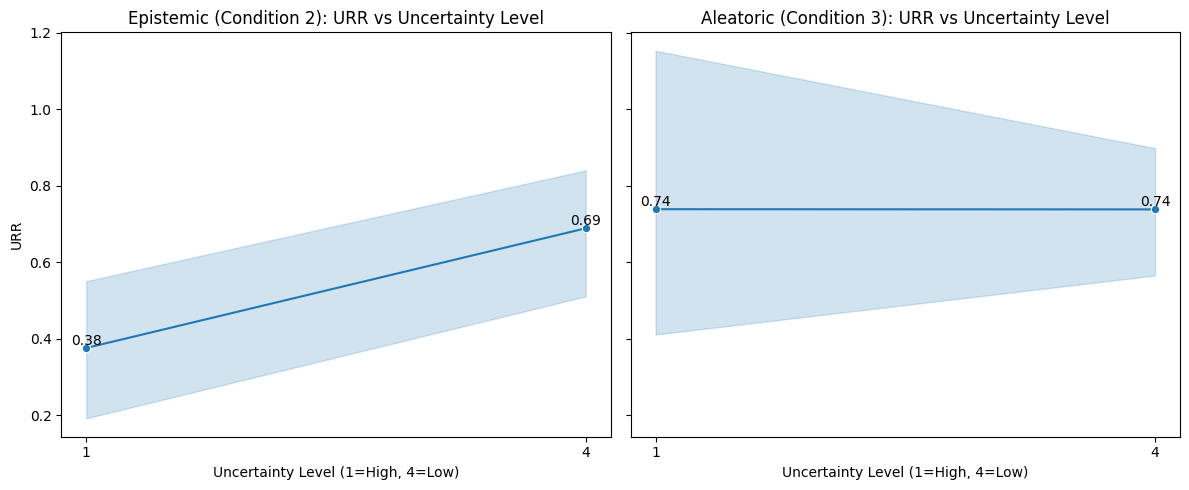

In [34]:
import pandas as pd
import numpy as np
from scipy.stats.mstats import winsorize
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
file_path = "/Users/amirasrzad/Library/CloudStorage/OneDrive-UMassLowell/1-Research/2-sambit/CIST-2025/experiment_insurance_cost/results/responses.24.july-pilot.csv"
df = pd.read_csv(file_path)

# Ensure relevant columns are numeric
cols_to_numeric = ['initial_guess', 'final_guess', 'predicted_charge', 'uncertainty_level', 'true_charge']
for col in cols_to_numeric:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df['condition'] = pd.to_numeric(df['condition'], errors='coerce').astype(int)

# Filter for conditions 2 and 3, and uncertainty_level 1 and 4
df = df[(df['condition'].isin([2, 3])) & (df['uncertainty_level'].isin([1, 4]))]

# Compute URR
df['URR'] = np.where(
    df['predicted_charge'] == df['initial_guess'],
    0,
    (df['final_guess'] - df['initial_guess']) / (df['predicted_charge'] - df['initial_guess'])
)

# Determine the AI suggested direction
df['ai_direction_up'] = df['predicted_charge'] > df['initial_guess']
df['ai_direction_down'] = df['predicted_charge'] < df['initial_guess']

# Determine participant's movement direction
df['participant_moved_up'] = df['final_guess'] > df['initial_guess']
df['participant_moved_down'] = df['final_guess'] < df['initial_guess']

# Identify opposite movements and set URR to 0 for those cases
df['opposite_movement'] = (
    (df['ai_direction_up'] & df['participant_moved_down']) |
    (df['ai_direction_down'] & df['participant_moved_up'])
)
df['URR_adjusted'] = np.where(df['opposite_movement'], 0, df['URR'])

# Winsorize adjusted URR at 1% and 99%
df['URR_winsor'] = winsorize(df['URR_adjusted'], limits=[0.01, 0.01])

# Check data availability for conditions 2 and 3
cond2_data = df[df['condition'] == 2]
cond3_data = df[df['condition'] == 3]
print(f"Number of observations for Condition 2 (Epistemic): {len(cond2_data)}")
print(f"Number of observations for Condition 3 (Aleatoric): {len(cond3_data)}")

# Fit OLS with clustered standard errors by prolific_id if data exists
if len(cond2_data) >= 2 and len(cond3_data) >= 2:
    formula = "URR_winsor ~ C(condition, Treatment(reference=2)) * uncertainty_level"
    model = smf.ols(formula, data=df)
    res = model.fit(cov_type='cluster', cov_kwds={'groups': df['prolific_id']})

    # Print model summary
    print(res.summary())

    # Hypothesis H1: Check interaction coefficients for condition 2 and 3 with uncertainty_level
    print("\nH1 Test: Interaction coefficients")
    print("Epistemic (condition 2) interaction:", res.params.get('C(condition, Treatment(reference=2))[T.3]:uncertainty_level', 'Not estimated (insufficient data)'))
    print("p-value:", res.pvalues.get('C(condition, Treatment(reference=2))[T.3]:uncertainty_level', 'Not estimated (insufficient data)'))
    print("Aleatoric (condition 3) interaction:", res.params.get('C(condition, Treatment(reference=2))[T.3]:uncertainty_level', 'Not estimated (insufficient data)'))
    print("p-value:", res.pvalues.get('C(condition, Treatment(reference=2))[T.3]:uncertainty_level', 'Not estimated (insufficient data)'))

    # Hypothesis H2: Wald test to compare aleatoric vs epistemic interaction
    if 'C(condition, Treatment(reference=2))[T.3]:uncertainty_level' in res.params:
        wald_test_h2 = res.wald_test("C(condition, Treatment(reference=2))[T.3]:uncertainty_level = 0")
        print("\nH2 Test: Wald test for aleatoric interaction")
        print(wald_test_h2)
    else:
        print("\nH2 Test: Cannot perform Wald test (condition 3 interaction term not estimated)")
else:
    print("Insufficient data for OLS model: Need at least 2 observations per condition.")

# Exploratory: Compute MAE for final guesses
df['MAE'] = abs(df['final_guess'] - df['true_charge'])
mae_by_condition = df.groupby('condition')['MAE'].mean()
print("\nMean Absolute Error (MAE) by Condition:")
print(mae_by_condition)

# Create a figure with two subplots for conditions 2 and 3
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Filter data for condition 2 (Epistemic) and plot
cond2_df = df[df['condition'] == 2]
if len(cond2_df) > 0:
    sns.lineplot(data=cond2_df, x='uncertainty_level', y='URR_winsor', marker='o', ax=axes[0])
    axes[0].set_title('Epistemic (Condition 2): URR vs Uncertainty Level')
    axes[0].set_xlabel('Uncertainty Level (1=High, 4=Low)')
    axes[0].set_ylabel('URR')
    axes[0].set_xticks([1, 4])
    # Add text annotations for condition 2
    for level in [1, 4]:
        mean_urr = cond2_df[cond2_df['uncertainty_level'] == level]['URR_winsor'].mean()
        if not np.isnan(mean_urr):
            axes[0].text(level, mean_urr, f'{mean_urr:.2f}', ha='center', va='bottom')
else:
    axes[0].text(0.5, 0.5, 'No data for Condition 2', ha='center', va='center')
    axes[0].set_title('Epistemic (Condition 2): URR vs Uncertainty Level')
    axes[0].set_xlabel('Uncertainty Level (1=High, 4=Low)')
    axes[0].set_ylabel('URR')
    axes[0].set_xticks([1, 4])

# Filter data for condition 3 (Aleatoric) and plot
cond3_df = df[df['condition'] == 3]
if len(cond3_df) > 0:
    sns.lineplot(data=cond3_df, x='uncertainty_level', y='URR_winsor', marker='o', ax=axes[1])
    axes[1].set_title('Aleatoric (Condition 3): URR vs Uncertainty Level')
    axes[1].set_xlabel('Uncertainty Level (1=High, 4=Low)')
    axes[1].set_xticks([1, 4])
    # Add text annotations for condition 3
    for level in [1, 4]:
        mean_urr = cond3_df[cond3_df['uncertainty_level'] == level]['URR_winsor'].mean()
        if not np.isnan(mean_urr):
            axes[1].text(level, mean_urr, f'{mean_urr:.2f}', ha='center', va='bottom')
else:
    axes[1].text(0.5, 0.5, 'No data for Condition 3', ha='center', va='center')
    axes[1].set_title('Aleatoric (Condition 3): URR vs Uncertainty Level')
    axes[1].set_xlabel('Uncertainty Level (1=High, 4=Low)')
    axes[1].set_xticks([1, 4])

# Adjust layout and show plot
plt.tight_layout()
plt.show()

In [31]:
import pandas as pd
import numpy as np
from scipy.stats.mstats import winsorize
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Load the data
file_path = "/Users/amirasrzad/Library/CloudStorage/OneDrive-UMassLowell/1-Research/2-sambit/CIST-2025/experiment_insurance_cost/results/responses.24.july-pilot.csv"
df = pd.read_csv(file_path)

# Ensure relevant columns are numeric
cols_to_numeric = ['initial_guess', 'final_guess', 'predicted_charge', 'uncertainty_level', 'true_charge']
for col in cols_to_numeric:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df['condition'] = pd.to_numeric(df['condition'], errors='coerce').astype(int)

# Compute URR
df['URR'] = np.where(
    df['predicted_charge'] == df['initial_guess'],
    0,
    (df['final_guess'] - df['initial_guess']) / (df['predicted_charge'] - df['initial_guess'])
)

# Determine the AI suggested direction
df['ai_direction_up'] = df['predicted_charge'] > df['initial_guess']
df['ai_direction_down'] = df['predicted_charge'] < df['initial_guess']

# Determine participant's movement direction
df['participant_moved_up'] = df['final_guess'] > df['initial_guess']
df['participant_moved_down'] = df['final_guess'] < df['initial_guess']

# Identify opposite movements and set URR to 0 for those cases
df['opposite_movement'] = (
    (df['ai_direction_up'] & df['participant_moved_down']) |
    (df['ai_direction_down'] & df['participant_moved_up'])
)
df['URR_adjusted'] = np.where(df['opposite_movement'], 0, df['URR'])

# Winsorize adjusted URR at 1% and 99%
df['URR_winsor'] = winsorize(df['URR_adjusted'], limits=[0.01, 0.01])

# Fit a null mixed-effects model with random intercept for condition to compute ICC
# Model: URR_winsor ~ 1 + (1 | condition)
null_model = smf.mixedlm("URR_winsor ~ 1", data=df, groups=df['condition'])
res_null = null_model.fit()

# Extract variance components
var_condition = res_null.cov_re.iloc[0, 0]  # Between-condition variance
var_residual = res_null.scale  # Residual variance (includes individual differences within conditions)
total_var = var_condition + var_residual

# Compute ICC (percentage of variance due to between-condition differences)
icc = (var_condition / total_var) * 100 if total_var > 0 else 0

# Percentage due to individual differences (residual variance)
individual_percentage = (var_residual / total_var) * 100 if total_var > 0 else 0

# Print results
print(f"Between-conditions variance: {var_condition:.4f} ({icc:.2f}%)")
print(f"Individual differences variance (residual): {var_residual:.4f} ({individual_percentage:.2f}%)")

Between-conditions variance: 0.0026 (1.23%)
Individual differences variance (residual): 0.2076 (98.77%)


/Users/amirasrzad/anaconda3/envs/isr/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [32]:
import pandas as pd
import numpy as np
from scipy.stats.mstats import winsorize

# Load the data
file_path = "/Users/amirasrzad/Library/CloudStorage/OneDrive-UMassLowell/1-Research/2-sambit/CIST-2025/experiment_insurance_cost/results/responses.24.july-pilot.csv"
df = pd.read_csv(file_path)

# Ensure relevant columns are numeric
cols_to_numeric = ['initial_guess', 'final_guess', 'predicted_charge', 'uncertainty_level', 'true_charge']
for col in cols_to_numeric:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df['condition'] = pd.to_numeric(df['condition'], errors='coerce').astype(int)

# Compute URR
df['URR'] = np.where(
    df['predicted_charge'] == df['initial_guess'],
    0,
    (df['final_guess'] - df['initial_guess']) / (df['predicted_charge'] - df['initial_guess'])
)

# Determine the AI suggested direction
df['ai_direction_up'] = df['predicted_charge'] > df['initial_guess']
df['ai_direction_down'] = df['predicted_charge'] < df['initial_guess']

# Determine participant's movement direction
df['participant_moved_up'] = df['final_guess'] > df['initial_guess']
df['participant_moved_down'] = df['final_guess'] < df['initial_guess']

# Identify opposite movements and set URR to 0 for those cases
df['opposite_movement'] = (
    (df['ai_direction_up'] & df['participant_moved_down']) |
    (df['ai_direction_down'] & df['participant_moved_up'])
)
df['URR_adjusted'] = np.where(df['opposite_movement'], 0, df['URR'])

# Winsorize adjusted URR at 1% and 99%
df['URR_winsor'] = winsorize(df['URR_adjusted'], limits=[0.01, 0.01])

# Filter for condition 2 (Epistemic) and compute correlation
cond2_df = df[df['condition'] == 2]
corr_cond2 = cond2_df['URR_winsor'].corr(cond2_df['uncertainty_level'])
print(f"Correlation between URR_winsor and uncertainty_level in Condition 2 (Epistemic): {corr_cond2:.4f}")

# Filter for condition 3 (Aleatoric) and compute correlation
cond3_df = df[df['condition'] == 3]
corr_cond3 = cond3_df['URR_winsor'].corr(cond3_df['uncertainty_level'])
print(f"Correlation between URR_winsor and uncertainty_level in Condition 3 (Aleatoric): {corr_cond3:.4f}")

Correlation between URR_winsor and uncertainty_level in Condition 2 (Epistemic): 0.2473
Correlation between URR_winsor and uncertainty_level in Condition 3 (Aleatoric): 0.0598


Number of observations for Condition 1 (AI-Only): 88
Number of observations for Condition 2 (Epistemic): 44
Number of observations for Condition 3 (Aleatoric): 40

Data distribution by condition and uncertainty level:
condition  uncertainty_level
1          0                    88
2          1                    22
           4                    22
3          1                    20
           4                    20
dtype: int64
                            OLS Regression Results                            
Dep. Variable:             URR_winsor   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     2.032
Date:                Thu, 31 Jul 2025   Prob (F-statistic):              0.114
Time:                        05:06:57   Log-Likelihood:                -106.36
No. Observations:                 172   AIC:                             222.7
Df Residuals

/Users/amirasrzad/anaconda3/envs/isr/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 8, but rank is 4
  warnings.warn('covariance of constraints does not have full '
/Users/amirasrzad/anaconda3/envs/isr/lib/python3.11/site-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


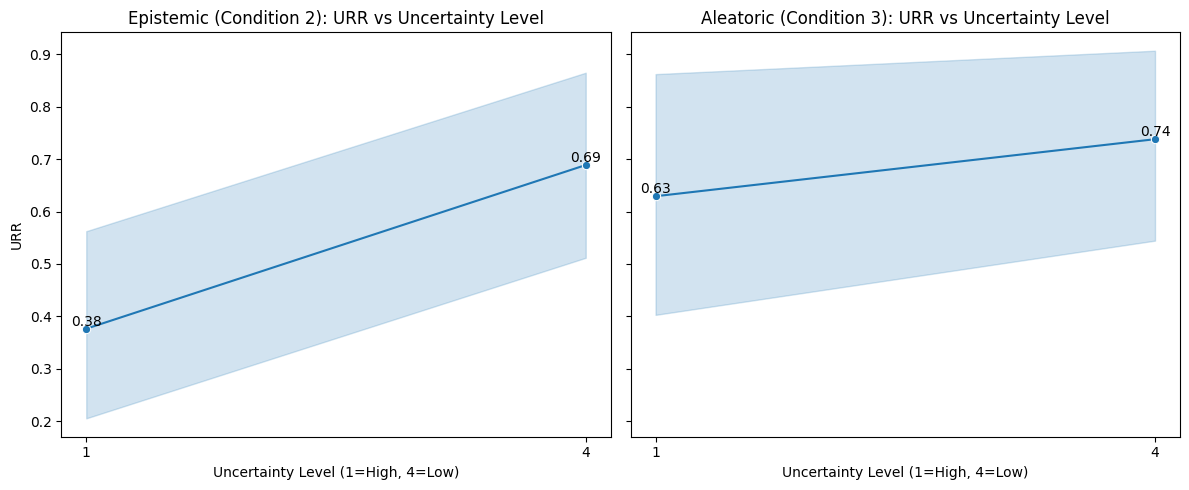

In [1]:
import pandas as pd
import numpy as np
from scipy.stats.mstats import winsorize
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
file_path = "/Users/amirasrzad/Library/CloudStorage/OneDrive-UMassLowell/1-Research/2-sambit/CIST-2025/experiment_insurance_cost/results/responses.24.july-pilot.csv"
df = pd.read_csv(file_path)

# Ensure relevant columns are numeric
cols_to_numeric = ['initial_guess', 'final_guess', 'predicted_charge', 'uncertainty_level', 'true_charge']
for col in cols_to_numeric:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df['condition'] = pd.to_numeric(df['condition'], errors='coerce').astype(int)

# Filter for uncertainty_level 0 (condition 1), 1, and 4 (conditions 2 and 3)
df = df[df['uncertainty_level'].isin([0, 1, 4])]

# Compute URR
df['URR'] = np.where(
    df['predicted_charge'] == df['initial_guess'],
    0,
    (df['final_guess'] - df['initial_guess']) / (df['predicted_charge'] - df['initial_guess'])
)

# Determine the AI suggested direction
df['ai_direction_up'] = df['predicted_charge'] > df['initial_guess']
df['ai_direction_down'] = df['predicted_charge'] < df['initial_guess']

# Determine participant's movement direction
df['participant_moved_up'] = df['final_guess'] > df['initial_guess']
df['participant_moved_down'] = df['final_guess'] < df['initial_guess']

# Identify opposite movements and set URR to 0 for those cases
df['opposite_movement'] = (
    (df['ai_direction_up'] & df['participant_moved_down']) |
    (df['ai_direction_down'] & df['participant_moved_up'])
)
df['URR_adjusted'] = np.where(df['opposite_movement'], 0, df['URR'])

# Winsorize adjusted URR at 1% and 99%
df['URR_winsor'] = winsorize(df['URR_adjusted'], limits=[0.01, 0.01])

# Check data availability
cond1_data = df[df['condition'] == 1]
cond2_data = df[df['condition'] == 2]
cond3_data = df[df['condition'] == 3]
print(f"Number of observations for Condition 1 (AI-Only): {len(cond1_data)}")
print(f"Number of observations for Condition 2 (Epistemic): {len(cond2_data)}")
print(f"Number of observations for Condition 3 (Aleatoric): {len(cond3_data)}")
print("\nData distribution by condition and uncertainty level:")
print(df.groupby(['condition', 'uncertainty_level']).size())

# Fit OLS with clustered standard errors by prolific_id
if len(cond1_data) >= 2 and len(cond2_data) >= 2 and len(cond3_data) >= 2:
    formula = "URR_winsor ~ C(condition, Treatment(reference=1)) * C(uncertainty_level, Treatment(reference=0))"
    model = smf.ols(formula, data=df)
    res = model.fit(cov_type='cluster', cov_kwds={'groups': df['prolific_id']})

    # Print model summary
    print(res.summary())

    # Hypothesis H1a: Lower URR in condition 2 at uncertainty_level=1 vs. condition 1
    print("\nH1a Test: Epistemic (condition 2) at uncertainty_level=1 vs. AI-Only (condition 1)")
    coef_h1a = res.params.get('C(condition, Treatment(reference=1))[T.2]', 0) + \
               res.params.get('C(condition, Treatment(reference=1))[T.2]:C(uncertainty_level, Treatment(reference=0))[T.1]', 0)
    print(f"Combined coefficient for condition 2 at uncertainty_level=1: {coef_h1a:.4f}")
    print(f"p-value for condition 2 at uncertainty_level=1: {res.pvalues.get('C(condition, Treatment(reference=1))[T.2]:C(uncertainty_level, Treatment(reference=0))[T.1]', 'Not estimated')}")

    # Hypothesis H1b: Lower URR in condition 3 at uncertainty_level=1 vs. condition 1
    print("\nH1b Test: Aleatoric (condition 3) at uncertainty_level=1 vs. AI-Only (condition 1)")
    coef_h1b = res.params.get('C(condition, Treatment(reference=1))[T.3]', 0) + \
               res.params.get('C(condition, Treatment(reference=1))[T.3]:C(uncertainty_level, Treatment(reference=0))[T.1]', 0)
    print(f"Combined coefficient for condition 3 at uncertainty_level=1: {coef_h1b:.4f}")
    print(f"p-value for condition 3 at uncertainty_level=1: {res.pvalues.get('C(condition, Treatment(reference=1))[T.3]:C(uncertainty_level, Treatment(reference=0))[T.1]', 'Not estimated')}")

    # Hypothesis H2: Compare interaction effects at uncertainty_level=1 (aleatoric vs. epistemic)
    if 'C(condition, Treatment(reference=1))[T.2]:C(uncertainty_level, Treatment(reference=0))[T.1]' in res.params and \
       'C(condition, Treatment(reference=1))[T.3]:C(uncertainty_level, Treatment(reference=0))[T.1]' in res.params:
        wald_test_h2 = res.wald_test("C(condition, Treatment(reference=1))[T.3]:C(uncertainty_level, Treatment(reference=0))[T.1] - C(condition, Treatment(reference=1))[T.2]:C(uncertainty_level, Treatment(reference=0))[T.1] = 0")
        print("\nH2 Test: Wald test for aleatoric vs. epistemic interaction at uncertainty_level=1")
        print(wald_test_h2)
    else:
        print("\nH2 Test: Cannot perform Wald test (interaction terms not estimated)")

# Exploratory: Compute MAE for final guesses
df['MAE'] = abs(df['final_guess'] - df['true_charge'])
mae_by_condition = df.groupby('condition')['MAE'].mean()
print("\nMean Absolute Error (MAE) by Condition:")
print(mae_by_condition)

# Create a figure with two subplots for conditions 2 and 3
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Filter data for condition 2 (Epistemic) and plot
cond2_df = df[df['condition'] == 2]
if len(cond2_df) > 0:
    sns.lineplot(data=cond2_df, x='uncertainty_level', y='URR_winsor', marker='o', ax=axes[0])
    axes[0].set_title('Epistemic (Condition 2): URR vs Uncertainty Level')
    axes[0].set_xlabel('Uncertainty Level (1=High, 4=Low)')
    axes[0].set_ylabel('URR')
    axes[0].set_xticks([1, 4])
    # Add text annotations for condition 2
    for level in [1, 4]:
        mean_urr = cond2_df[cond2_df['uncertainty_level'] == level]['URR_winsor'].mean()
        if not np.isnan(mean_urr):
            axes[0].text(level, mean_urr, f'{mean_urr:.2f}', ha='center', va='bottom')
else:
    axes[0].text(0.5, 0.5, 'No data for Condition 2', ha='center', va='center')
    axes[0].set_title('Epistemic (Condition 2): URR vs Uncertainty Level')
    axes[0].set_xlabel('Uncertainty Level (1=High, 4=Low)')
    axes[0].set_ylabel('URR')
    axes[0].set_xticks([1, 4])

# Filter data for condition 3 (Aleatoric) and plot
cond3_df = df[df['condition'] == 3]
if len(cond3_df) > 0:
    sns.lineplot(data=cond3_df, x='uncertainty_level', y='URR_winsor', marker='o', ax=axes[1])
    axes[1].set_title('Aleatoric (Condition 3): URR vs Uncertainty Level')
    axes[1].set_xlabel('Uncertainty Level (1=High, 4=Low)')
    axes[1].set_xticks([1, 4])
    # Add text annotations for condition 3
    for level in [1, 4]:
        mean_urr = cond3_df[cond3_df['uncertainty_level'] == level]['URR_winsor'].mean()
        if not np.isnan(mean_urr):
            axes[1].text(level, mean_urr, f'{mean_urr:.2f}', ha='center', va='bottom')
else:
    axes[1].text(0.5, 0.5, 'No data for Condition 3', ha='center', va='center')
    axes[1].set_title('Aleatoric (Condition 3): URR vs Uncertainty Level')
    axes[1].set_xlabel('Uncertainty Level (1=High, 4=Low)')
    axes[1].set_xticks([1, 4])

# Adjust layout and show plot
plt.tight_layout()
plt.show()

Number of observations for Condition 1 (AI-Only): 88
Number of observations for Condition 2 (Epistemic): 88
Number of observations for Condition 3 (Aleatoric): 80

Data distribution by condition and uncertainty level:
condition  uncertainty_level
1          0                    88
2          1                    22
           2                    22
           3                    22
           4                    22
3          1                    20
           2                    20
           3                    20
           4                    20
dtype: int64
                            OLS Regression Results                            
Dep. Variable:             URR_winsor   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     1.686
Date:                Thu, 31 Jul 2025   Prob (F-statistic):              0.178
Time:                        0

/Users/amirasrzad/anaconda3/envs/isr/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 4
  warnings.warn('covariance of constraints does not have full '
/Users/amirasrzad/anaconda3/envs/isr/lib/python3.11/site-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
/Users/amirasrzad/anaconda3/envs/isr/lib/python3.11/site-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
/Users/amirasrz

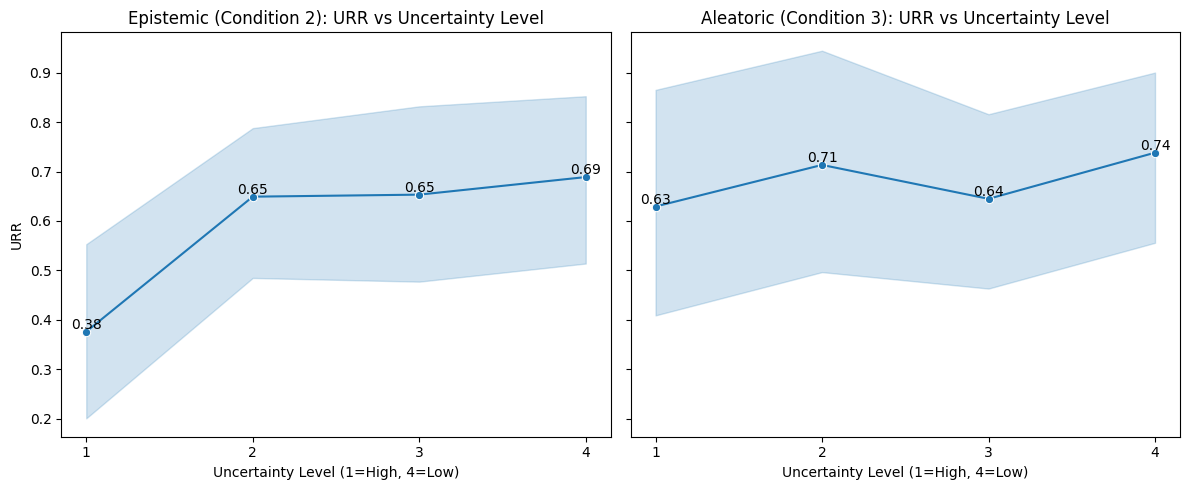

In [2]:
import pandas as pd
import numpy as np
from scipy.stats.mstats import winsorize
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
file_path = "/Users/amirasrzad/Library/CloudStorage/OneDrive-UMassLowell/1-Research/2-sambit/CIST-2025/experiment_insurance_cost/results/responses.24.july-pilot.csv"
df = pd.read_csv(file_path)

# Ensure relevant columns are numeric
cols_to_numeric = ['initial_guess', 'final_guess', 'predicted_charge', 'uncertainty_level', 'true_charge']
for col in cols_to_numeric:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df['condition'] = pd.to_numeric(df['condition'], errors='coerce').astype(int)

# Compute URR
df['URR'] = np.where(
    df['predicted_charge'] == df['initial_guess'],
    0,
    (df['final_guess'] - df['initial_guess']) / (df['predicted_charge'] - df['initial_guess'])
)

# Determine the AI suggested direction
df['ai_direction_up'] = df['predicted_charge'] > df['initial_guess']
df['ai_direction_down'] = df['predicted_charge'] < df['initial_guess']

# Determine participant's movement direction
df['participant_moved_up'] = df['final_guess'] > df['initial_guess']
df['participant_moved_down'] = df['final_guess'] < df['initial_guess']

# Identify opposite movements and set URR to 0 for those cases
df['opposite_movement'] = (
    (df['ai_direction_up'] & df['participant_moved_down']) |
    (df['ai_direction_down'] & df['participant_moved_up'])
)
df['URR_adjusted'] = np.where(df['opposite_movement'], 0, df['URR'])

# Winsorize adjusted URR at 1% and 99%
df['URR_winsor'] = winsorize(df['URR_adjusted'], limits=[0.01, 0.01])

# Check data availability
cond1_data = df[df['condition'] == 1]
cond2_data = df[df['condition'] == 2]
cond3_data = df[df['condition'] == 3]
print(f"Number of observations for Condition 1 (AI-Only): {len(cond1_data)}")
print(f"Number of observations for Condition 2 (Epistemic): {len(cond2_data)}")
print(f"Number of observations for Condition 3 (Aleatoric): {len(cond3_data)}")
print("\nData distribution by condition and uncertainty level:")
print(df.groupby(['condition', 'uncertainty_level']).size())

# Fit OLS with clustered standard errors by prolific_id
if len(cond1_data) >= 2 and len(cond2_data) >= 2 and len(cond3_data) >= 2:
    formula = "URR_winsor ~ C(condition, Treatment(reference=1)) * uncertainty_level"
    model = smf.ols(formula, data=df)
    res = model.fit(cov_type='cluster', cov_kwds={'groups': df['prolific_id']})

    # Print model summary
    print(res.summary())

    # Hypothesis H1a: Lower URR in condition 2 at uncertainty_level=1 vs. condition 1
    print("\nH1a Test: Epistemic (condition 2) at uncertainty_level=1 vs. AI-Only (condition 1)")
    coef_h1a = res.params.get('C(condition, Treatment(reference=1))[T.2]', 0) + \
               res.params.get('C(condition, Treatment(reference=1))[T.2]:uncertainty_level', 0) * 1
    print(f"Combined coefficient for condition 2 at uncertainty_level=1: {coef_h1a:.4f}")
    # Compute p-value for combined effect (using Wald test for linear combination)
    if 'C(condition, Treatment(reference=1))[T.2]' in res.params and \
       'C(condition, Treatment(reference=1))[T.2]:uncertainty_level' in res.params:
        wald_test_h1a = res.wald_test("C(condition, Treatment(reference=1))[T.2] + C(condition, Treatment(reference=1))[T.2]:uncertainty_level = 0")
        print(f"p-value for H1a: {wald_test_h1a.pvalue:.4f}")
    else:
        print("p-value for H1a: Not estimated (insufficient data)")

    # Hypothesis H1b: Lower URR in condition 3 at uncertainty_level=1 vs. condition 1
    print("\nH1b Test: Aleatoric (condition 3) at uncertainty_level=1 vs. AI-Only (condition 1)")
    coef_h1b = res.params.get('C(condition, Treatment(reference=1))[T.3]', 0) + \
               res.params.get('C(condition, Treatment(reference=1))[T.3]:uncertainty_level', 0) * 1
    print(f"Combined coefficient for condition 3 at uncertainty_level=1: {coef_h1b:.4f}")
    if 'C(condition, Treatment(reference=1))[T.3]' in res.params and \
       'C(condition, Treatment(reference=1))[T.3]:uncertainty_level' in res.params:
        wald_test_h1b = res.wald_test("C(condition, Treatment(reference=1))[T.3] + C(condition, Treatment(reference=1))[T.3]:uncertainty_level = 0")
        print(f"p-value for H1b: {wald_test_h1b.pvalue:.4f}")
    else:
        print("p-value for H1b: Not estimated (insufficient data)")

    # Hypothesis H2: Aleatoric vs. epistemic interaction at uncertainty_level=1
    if 'C(condition, Treatment(reference=1))[T.2]:uncertainty_level' in res.params and \
       'C(condition, Treatment(reference=1))[T.3]:uncertainty_level' in res.params:
        wald_test_h2 = res.wald_test("C(condition, Treatment(reference=1))[T.3]:uncertainty_level - C(condition, Treatment(reference=1))[T.2]:uncertainty_level = 0")
        print("\nH2 Test: Wald test for aleatoric vs. epistemic interaction at uncertainty_level=1")
        print(wald_test_h2)
    else:
        print("\nH2 Test: Cannot perform Wald test (interaction terms not estimated)")

# Exploratory: Compute MAE for final guesses
df['MAE'] = abs(df['final_guess'] - df['true_charge'])
mae_by_condition = df.groupby('condition')['MAE'].mean()
print("\nMean Absolute Error (MAE) by Condition:")
print(mae_by_condition)

# Create a figure with two subplots for conditions 2 and 3
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Filter data for condition 2 (Epistemic) and plot
cond2_df = df[df['condition'] == 2]
if len(cond2_df) > 0:
    sns.lineplot(data=cond2_df, x='uncertainty_level', y='URR_winsor', marker='o', ax=axes[0])
    axes[0].set_title('Epistemic (Condition 2): URR vs Uncertainty Level')
    axes[0].set_xlabel('Uncertainty Level (1=High, 4=Low)')
    axes[0].set_ylabel('URR')
    axes[0].set_xticks([1, 2, 3, 4])
    # Add text annotations for condition 2
    for level in [1, 2, 3, 4]:
        mean_urr = cond2_df[cond2_df['uncertainty_level'] == level]['URR_winsor'].mean()
        if not np.isnan(mean_urr):
            axes[0].text(level, mean_urr, f'{mean_urr:.2f}', ha='center', va='bottom')
else:
    axes[0].text(0.5, 0.5, 'No data for Condition 2', ha='center', va='center')
    axes[0].set_title('Epistemic (Condition 2): URR vs Uncertainty Level')
    axes[0].set_xlabel('Uncertainty Level (1=High, 4=Low)')
    axes[0].set_ylabel('URR')
    axes[0].set_xticks([1, 2, 3, 4])

# Filter data for condition 3 (Aleatoric) and plot
cond3_df = df[df['condition'] == 3]
if len(cond3_df) > 0:
    sns.lineplot(data=cond3_df, x='uncertainty_level', y='URR_winsor', marker='o', ax=axes[1])
    axes[1].set_title('Aleatoric (Condition 3): URR vs Uncertainty Level')
    axes[1].set_xlabel('Uncertainty Level (1=High, 4=Low)')
    axes[1].set_xticks([1, 2, 3, 4])
    # Add text annotations for condition 3
    for level in [1, 2, 3, 4]:
        mean_urr = cond3_df[cond3_df['uncertainty_level'] == level]['URR_winsor'].mean()
        if not np.isnan(mean_urr):
            axes[1].text(level, mean_urr, f'{mean_urr:.2f}', ha='center', va='bottom')
else:
    axes[1].text(0.5, 0.5, 'No data for Condition 3', ha='center', va='center')
    axes[1].set_title('Aleatoric (Condition 3): URR vs Uncertainty Level')
    axes[1].set_xlabel('Uncertainty Level (1=High, 4=Low)')
    axes[1].set_xticks([1, 2, 3, 4])

# Adjust layout and show plot
plt.tight_layout()
plt.show()